## Setup

In [32]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [33]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
task = 'PushButtons'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth())


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [35]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [42]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([83, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([83]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([83, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([83, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([83, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([83, 3, 256, 256]), device=cpu, dtype=torch.float32, is_s

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    trans_cov_mask_t_pos_corr = False,

    em_steps=1,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=5e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=3,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-02-09 02:34:06.788 | INFO     |  Fitting AutoTPGMM
2025-02-09 02:34:06.789 | INFO     |  Performing fitting actions: [INIT]
2025-02-09 02:34:06.789 | INFO     |  Segmenting trajectories


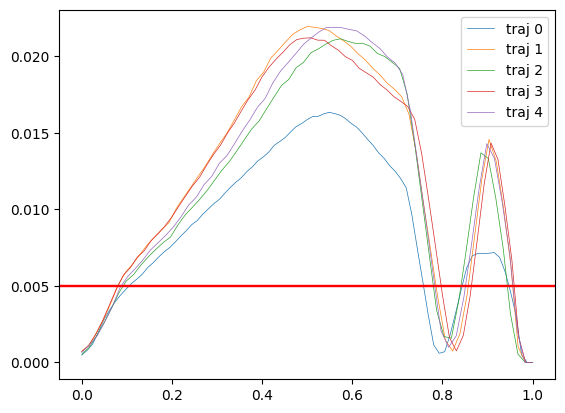

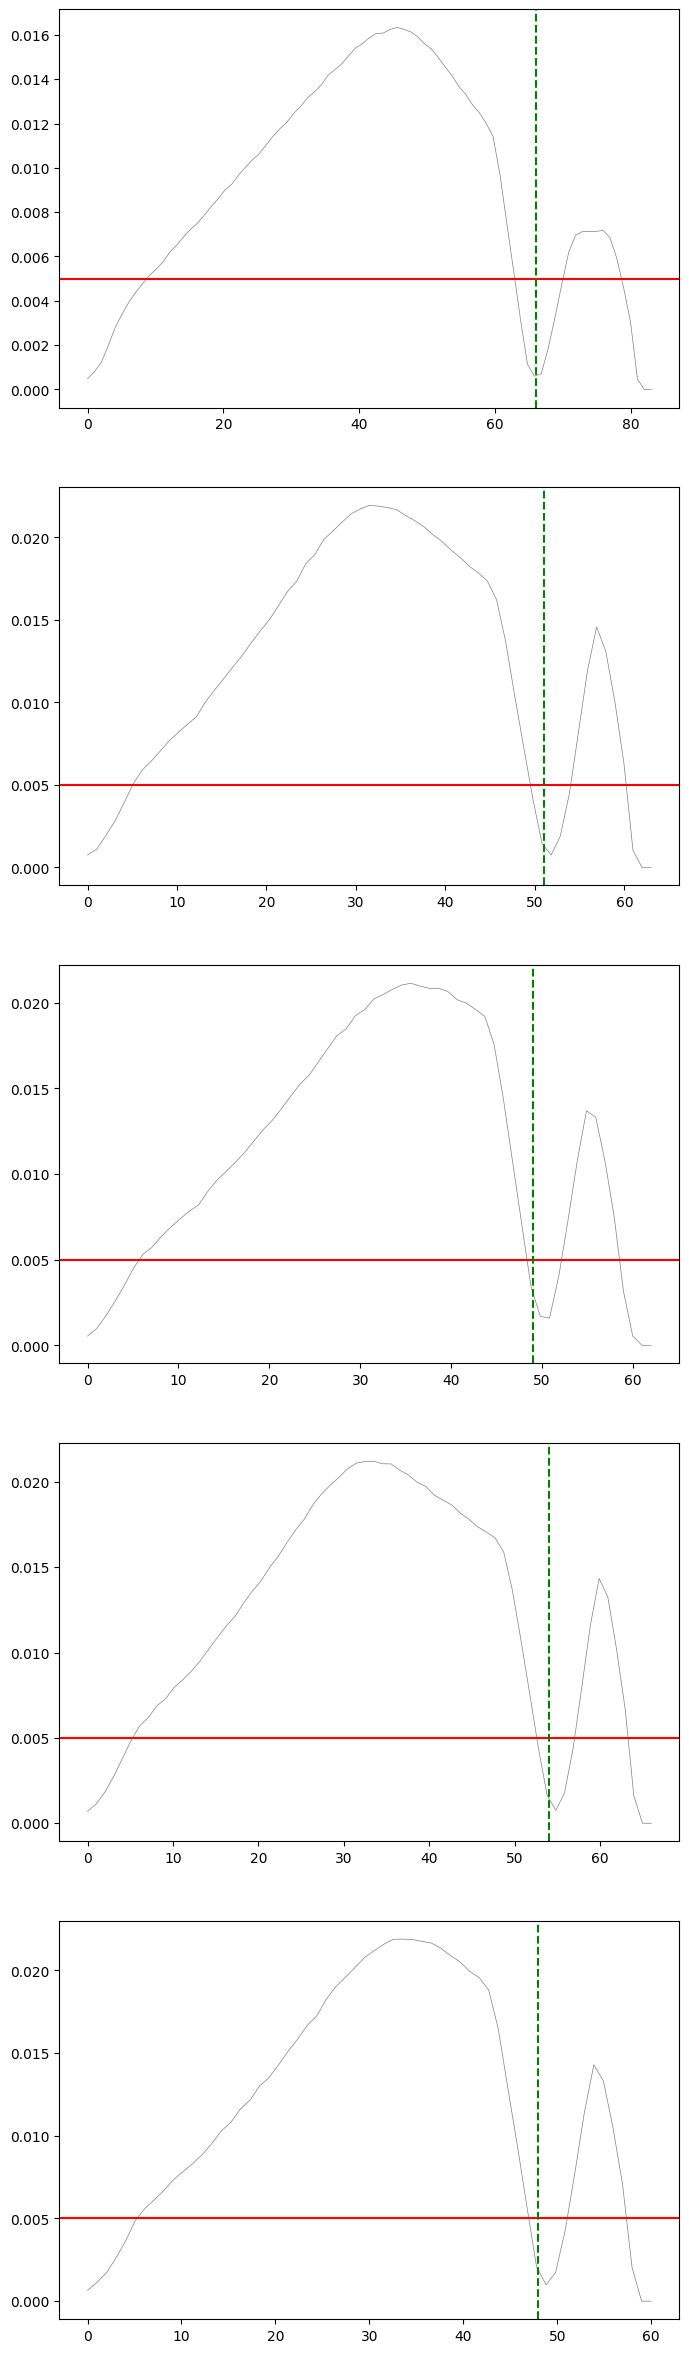

2025-02-09 02:34:08.098 | INFO     |  Creating segement of demos.
2025-02-09 02:34:08.104 | INFO     |  Subsampling to length 53 using strategy mean-length.
2025-02-09 02:34:08.106 | INFO     |  Creating segement of demos.
2025-02-09 02:34:08.111 | INFO     |  Subsampling to length 13 using strategy mean-length.
2025-02-09 02:34:08.113 | INFO     |  ... created 2 segments
2025-02-09 02:34:08.114 | INFO     |    Fitting candidate frame 1/4
2025-02-09 02:34:08.114 | INFO     |    Creating partial frame view of demos.
2025-02-09 02:34:08.122 | WARNING  |    Riemannian GMMs only make sense for rotations.
2025-02-09 02:34:08.123 | INFO     |    Manifold: TIME x R3 x R1
2025-02-09 02:34:08.123 | INFO     |    Changing number of components to 8
2025-02-09 02:34:08.123 | INFO     |    Model init ...


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-02-09 02:34:08.184 | INFO     |    Fitting candidate frame 2/4
2025-02-09 02:34:08.185 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-02-09 02:34:08.279 | INFO     |    Fitting candidate frame 3/4
2025-02-09 02:34:08.279 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-02-09 02:34:08.404 | INFO     |    Fitting candidate frame 4/4
2025-02-09 02:34:08.405 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2025-02-09 02:34:08.467 | INFO     |  ee_init    score (rel):     -1 (1.000)
2025-02-09 02:34:08.468 | INFO     |  obj000     score (rel):     -1 (0.998)
2025-02-09 02:34:08.468 | INFO     |  obj001     score (rel):     -0 (0.142)
2025-02-09 02:34:08.468 | INFO     |  obj002     score (rel):     -0 (0.086)
2025-02-09 02:34:08.469 | INFO     |  Creating partial frame view of demos.
2025-02-09 02:34:08.473 | INFO     |    Fitting candidate frame 1/4
2025-02-09 02:34:08.473 | INFO     |    Creating partial frame view of demos.
2025-02-09 02:34:08.484 | INFO     |    Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-02-09 02:34:08.517 | INFO     |    Fitting candidate frame 2/4
2025-02-09 02:34:08.518 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-02-09 02:34:08.567 | INFO     |    Fitting candidate frame 3/4
2025-02-09 02:34:08.567 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-02-09 02:34:08.615 | INFO     |    Fitting candidate frame 4/4
2025-02-09 02:34:08.616 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-02-09 02:34:08.666 | INFO     |  ee_init    score (rel):     -0 (0.002)
2025-02-09 02:34:08.666 | INFO     |  obj000     score (rel):     -1 (1.000)
2025-02-09 02:34:08.666 | INFO     |  obj001     score (rel):     -0 (0.002)
2025-02-09 02:34:08.667 | INFO     |  obj002     score (rel):     -0 (0.001)
2025-02-09 02:34:08.668 | INFO     |  Creating partial frame view of demos.
2025-02-09 02:34:08.672 | INFO     |  Segmented trajs into 2 segments
2025-02-09 02:34:08.699 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002
Segment 0 -0.995839 -0.993626 -0.141089 -0.085411
Segment 1 -0.001604 -0.995069 -0.002165 -0.001187
2025-02-09 02:34:08.705 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002
Segment 0  1.000000  0.997777  0.141678  0.085768
Segment 1  0.001611  1.000000  0.002176  0.001193


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-02-09 02:34:08.754 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[1.05e+007, 1.05e+007, 6.79e+006, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.47e+005, 1.22e+006, 2.01e+006, ..., 3.08e-205, 9.36e-212,
          9.38e-216],
         [3.32e-001, 3.14e+000, 2.38e+001, ..., 3.70e-121, 1.52e-125,
          2.25e-128],
         ...,
         [5.49e-042, 2.54e-039, 8.45e-037, ..., 2.69e+000, 4.58e-001,
          8.34e-002],
         [3.84e-065, 7.77e-063, 1.23e-060, ..., 9.77e+005, 4.79e+005,
          2.22e+005],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 8.23e+005, 1.05e+006,
          8.11e+005]]),
  array([[5.31e+05, 5.30e+05, 3.17e+05, 1.11e+05, 2.20e+04, 1.65e+03,
          8.99e+01, 2.73e+00, 2.17e-02, 2.17e-04, 1.49e-06, 7.13e-09,
          3.38e-11, 5.31e+05, 5.30e+05, 3.24e+05, 1.17e+05, 2.28e+04,
          1.98e+03, 6.46e+01, 3.49e+00, 3.34e-02, 2.08e-04, 1.12e-06,
          7.60e-09, 3.61e-11, 5.30e+05, 5.31e+05, 3.25e+05, 1.19e+05,
          2.41e+04, 2.32e+03, 8.88e+01, 1.50e+00, 1.51e-02, 1.17e-04,
          9.

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-02-09 02:34:37.764 | INFO     |  Did not specify time_based, deciding automatically.
2025-02-09 02:34:38.333 | WARNING  |  Skippig NaN Gaussians.


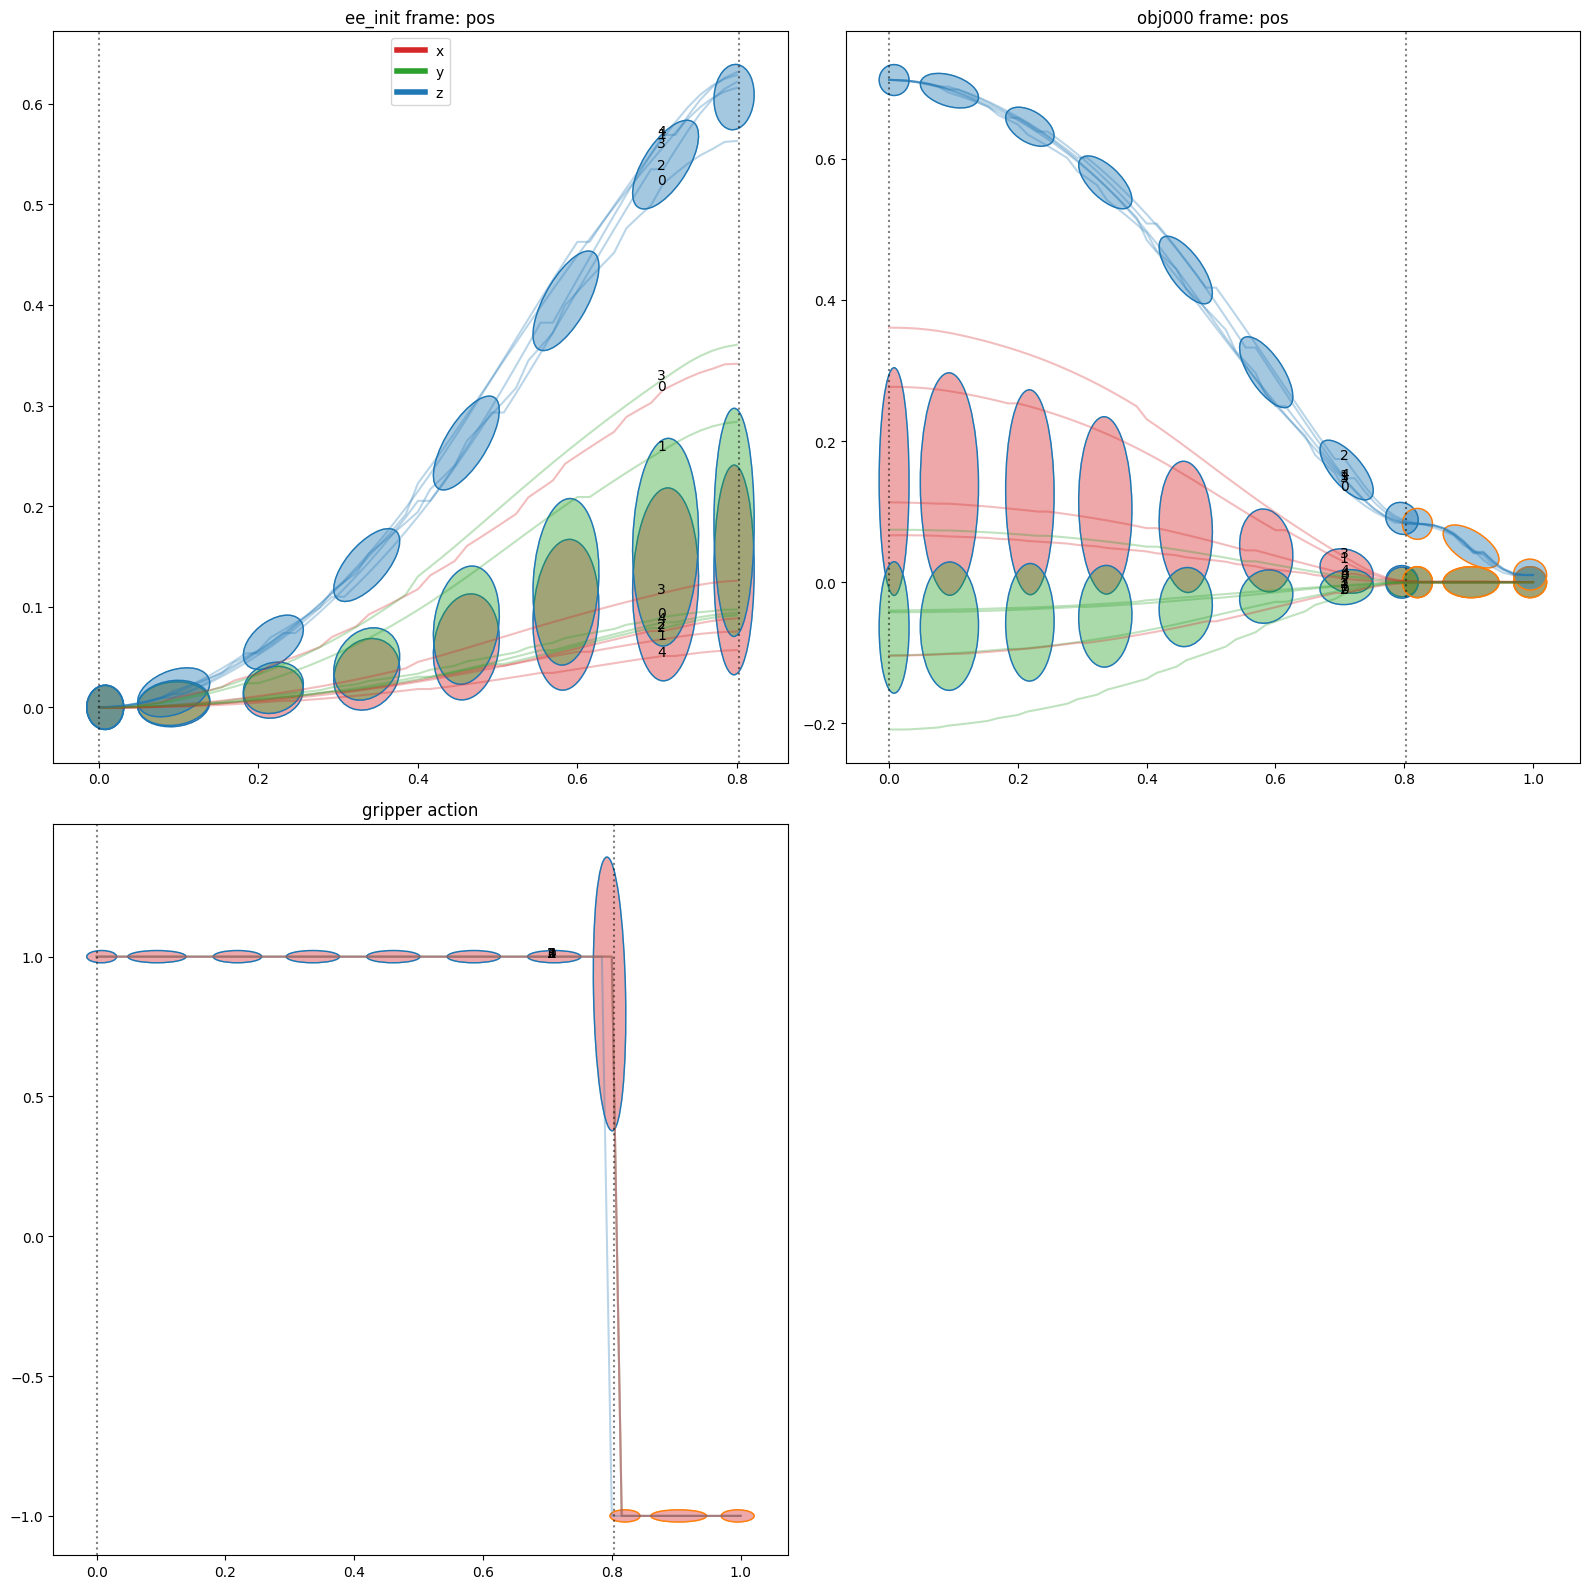

In [11]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [12]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-02-09 02:34:53.219 | INFO     |  Fitting AutoTPGMM
2025-02-09 02:34:53.220 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-02-09 02:34:53.235 | INFO     |  HMM EM ...
2025-02-09 02:34:53.238 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-09 02:34:53.273 | INFO     |  HMM init priors not defined, initializing to uniform
2025-02-09 02:34:53.395 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[9.42e-001, 8.96e-001, 7.72e-001, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [5.81e-002, 1.04e-001, 2.28e-001, ..., 1.71e-211, 6.13e-218,
          9.07e-222],
         [2.98e-008, 2.68e-007, 2.70e-006, ..., 2.06e-127, 9.99e-132,
          2.18e-134],
         ...,
         [4.92e-049, 2.17e-046, 9.59e-044, ..., 1.49e-006, 3.00e-007,
          8.07e-008],
         [3.44e-072, 6.64e-070, 1.40e-067, ..., 5.43e-001, 3.14e-001,
          2.15e-001],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 4.57e-001, 6.86e-001,
          7.85e-001]]),
  array([[9.45e-01, 8.91e-01, 7.36e-01, 3.93e-01, 8.86e-02, 6.15e-03,
          3.37e-04, 1.13e-05, 9.31e-08, 6.65e-10, 3.11e-12, 1.31e-14,
          7.81e-17, 9.45e-01, 8.91e-01, 7.44e-01, 4.13e-01, 9.21e-02,
          7.36e-03, 2.49e-04, 1.46e-05, 1.43e-07, 6.36e-10, 2.33e-12,
          1.39e-14, 8.33e-17, 9.44e-01, 8.91e-01, 7.45e-01, 4.20e-01,
          9.90e-02, 8.76e-03, 3.33e-04, 6.48e-06, 6.56e-08, 3.58e-10,
          1.

2025-02-09 02:35:01.893 | INFO     |  Did not specify time_based, deciding automatically.


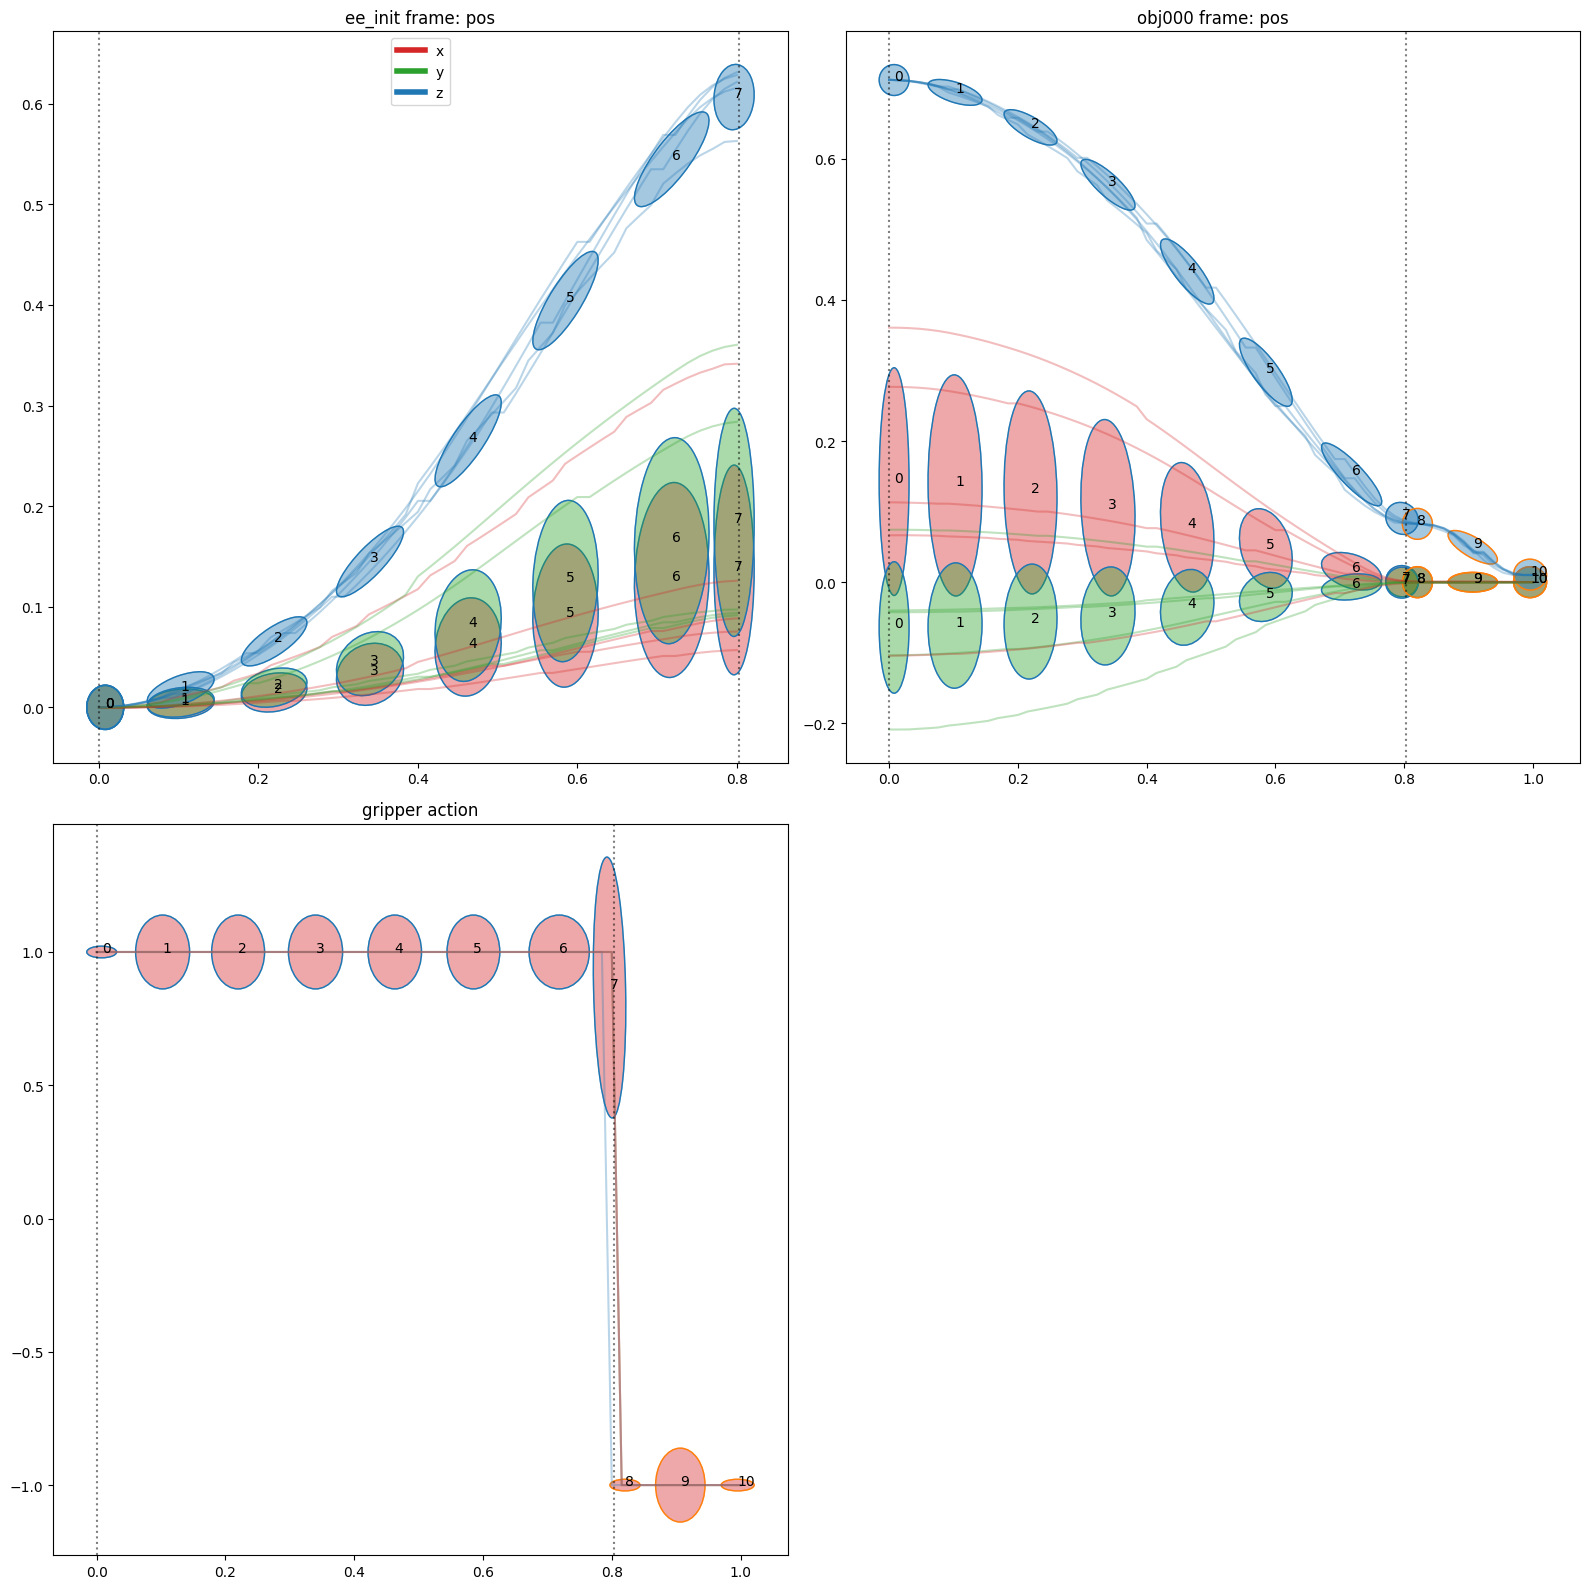

In [13]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

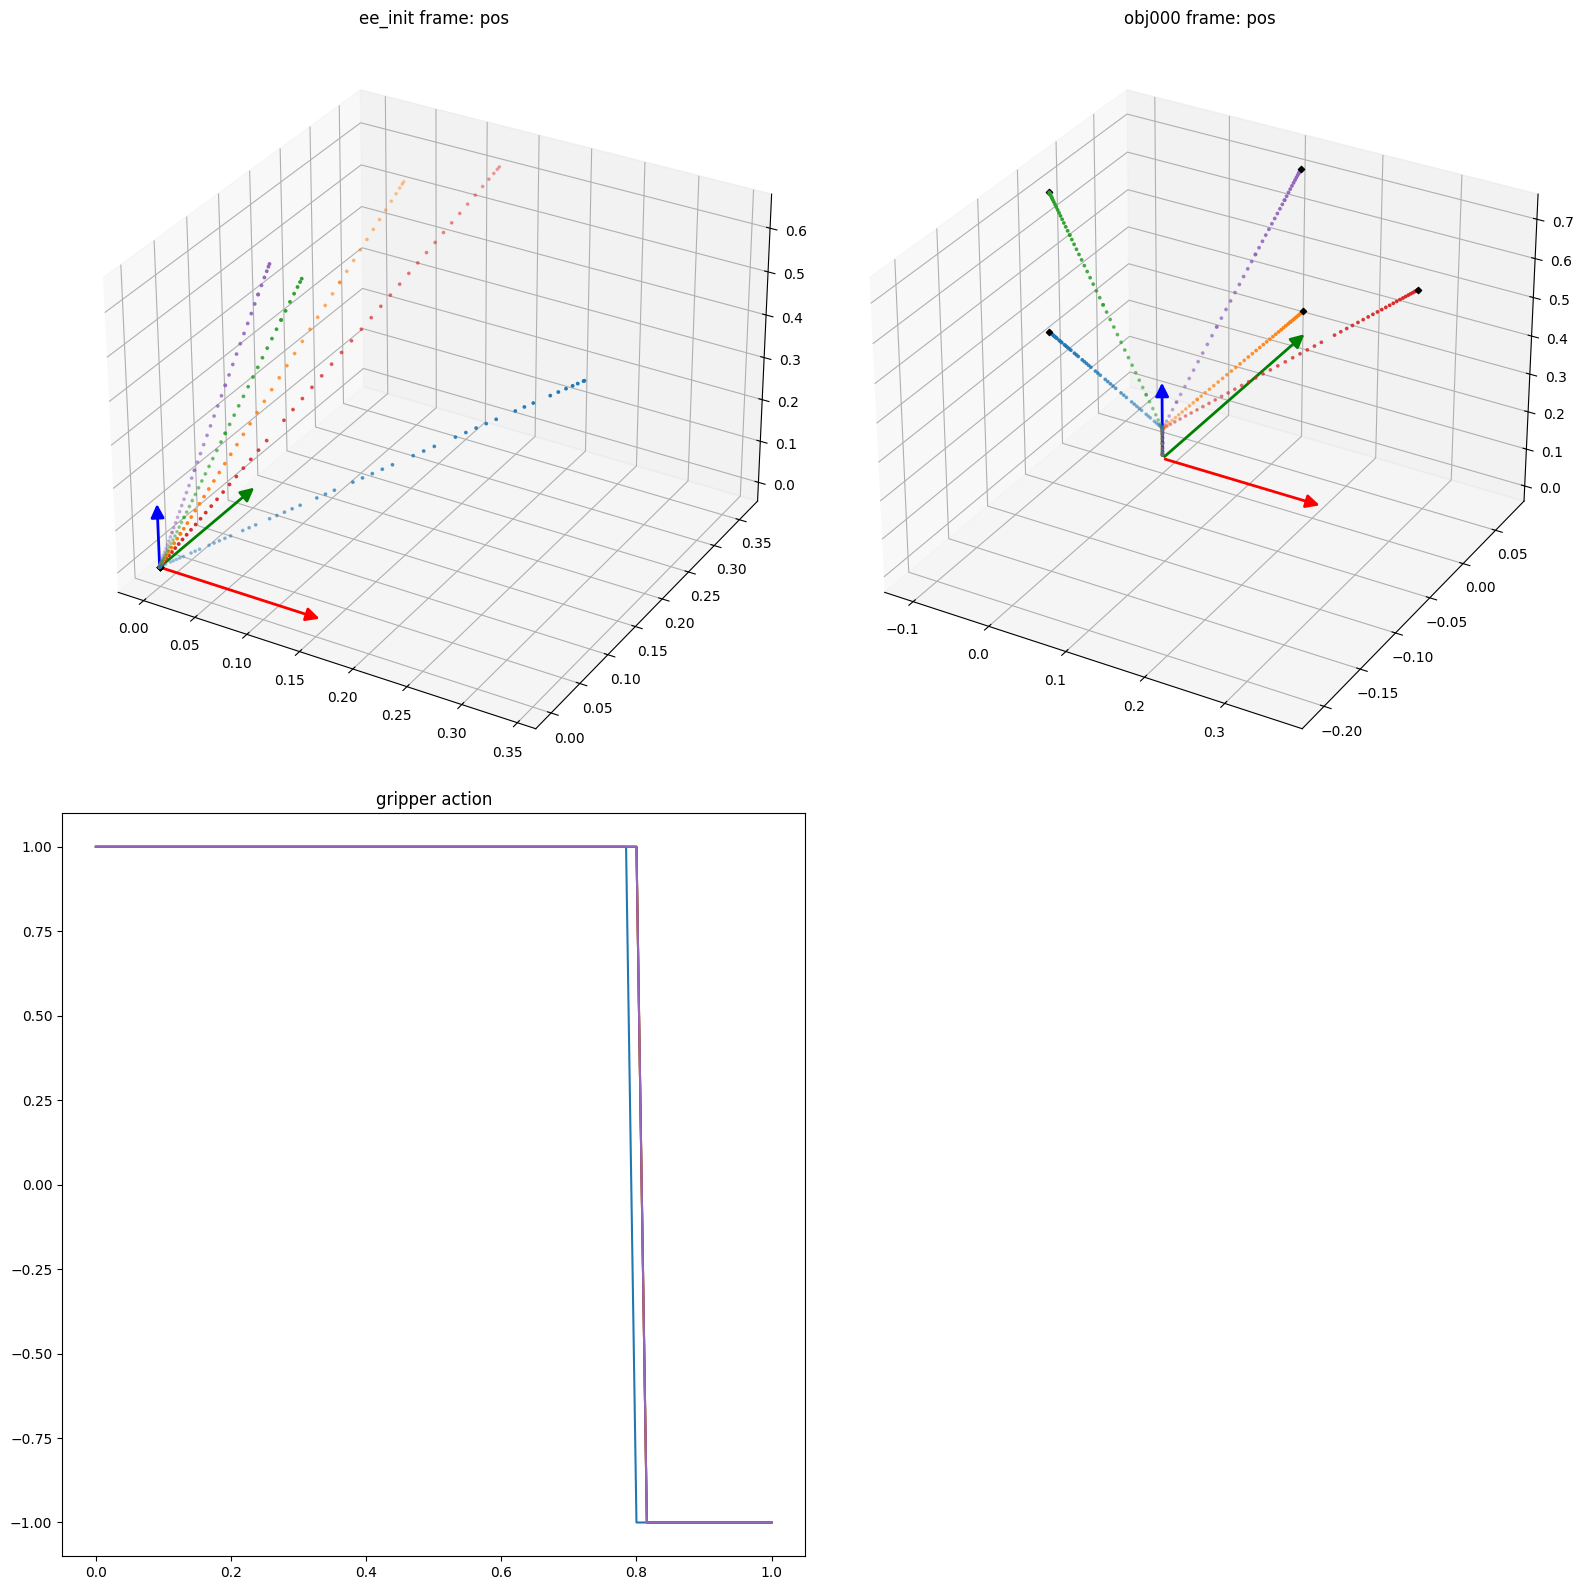

In [14]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

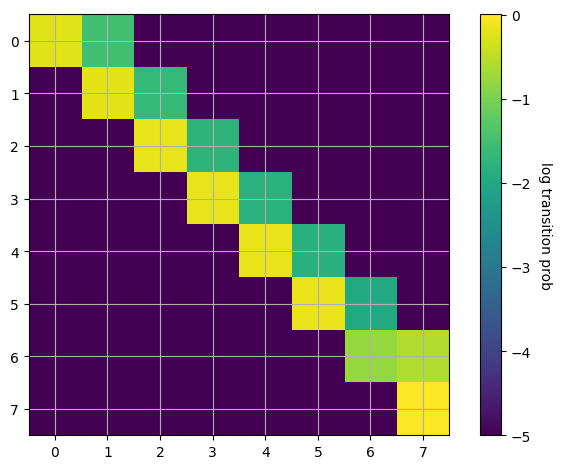

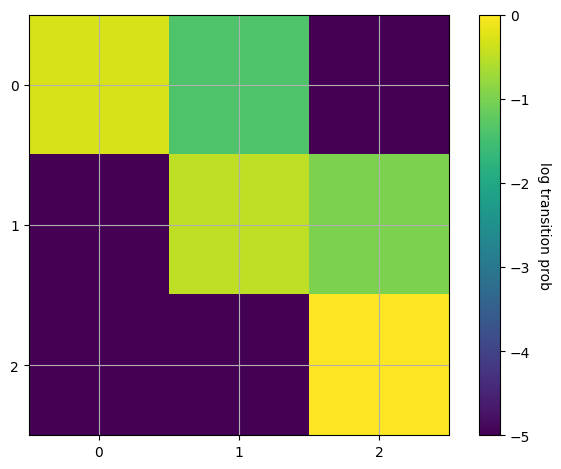

In [15]:
atpgmm.plot_hmm_transition_matrix()

In [16]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-02-09 02:35:32.592 | INFO     |  Saving model:


In [17]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-02-09 02:35:35.730 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-02-09 02:35:35.785 | INFO     |  Caculated segment transition probabilities: (array([[0.94]]),)
2025-02-09 02:35:35.786 | INFO     |  Creating partial frame view of demos.
2025-02-09 02:35:35.790 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-02-09 02:35:35.913 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-02-09 02:35:35.980 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

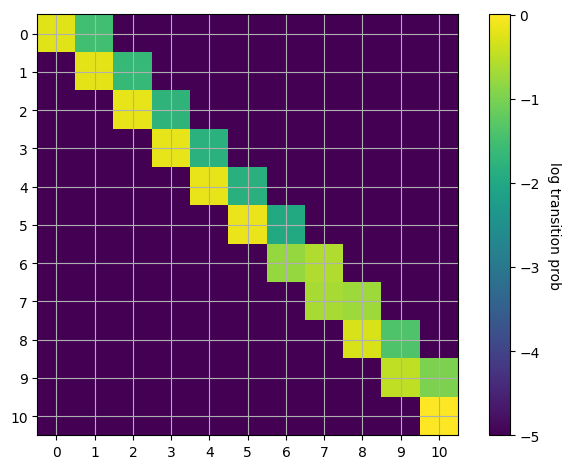

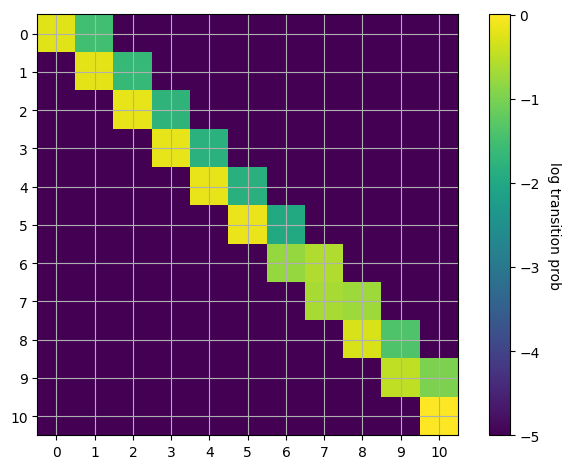

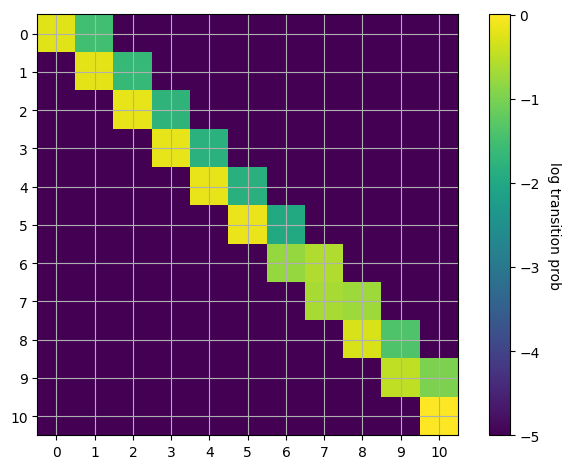

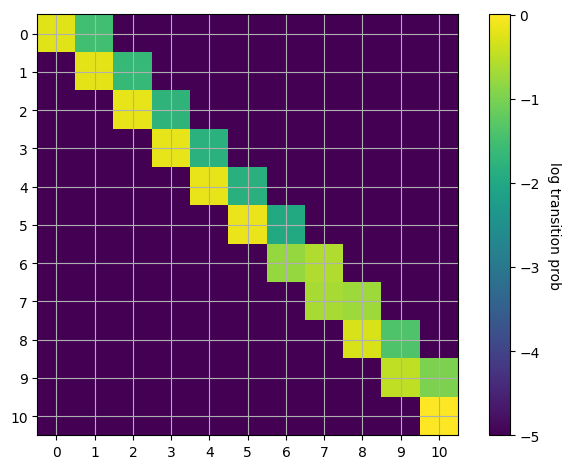

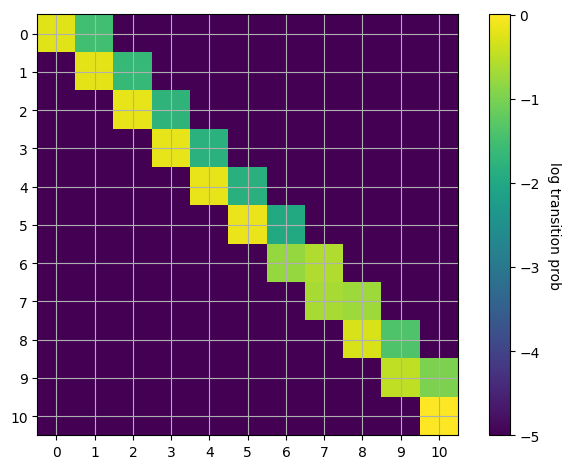

In [18]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-02-09 02:35:54.076 | INFO     |  Taking frame origins from demos.


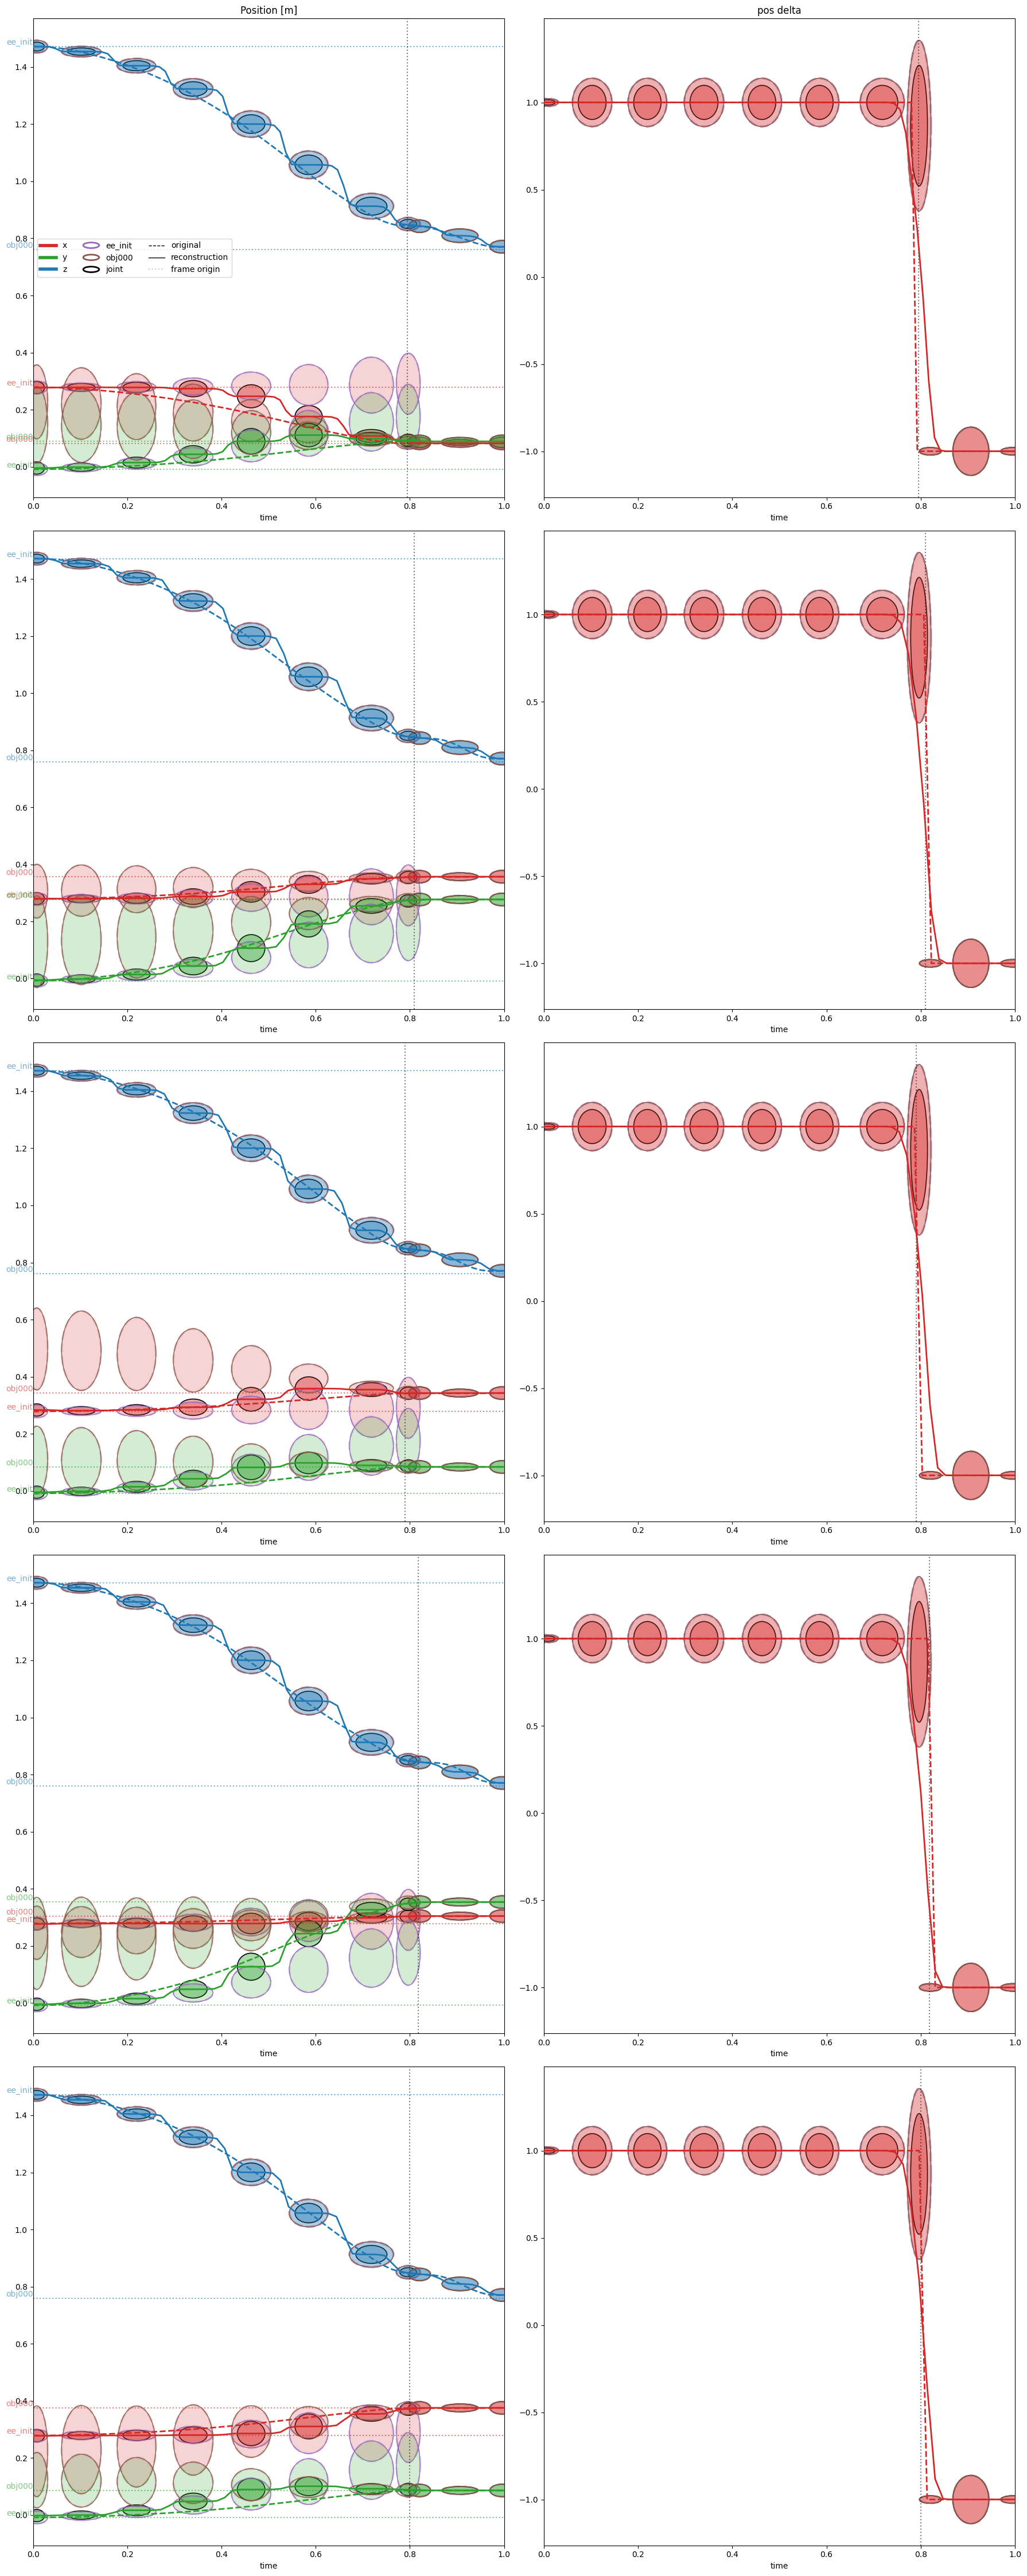

In [19]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2025-02-09 02:36:23.410 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


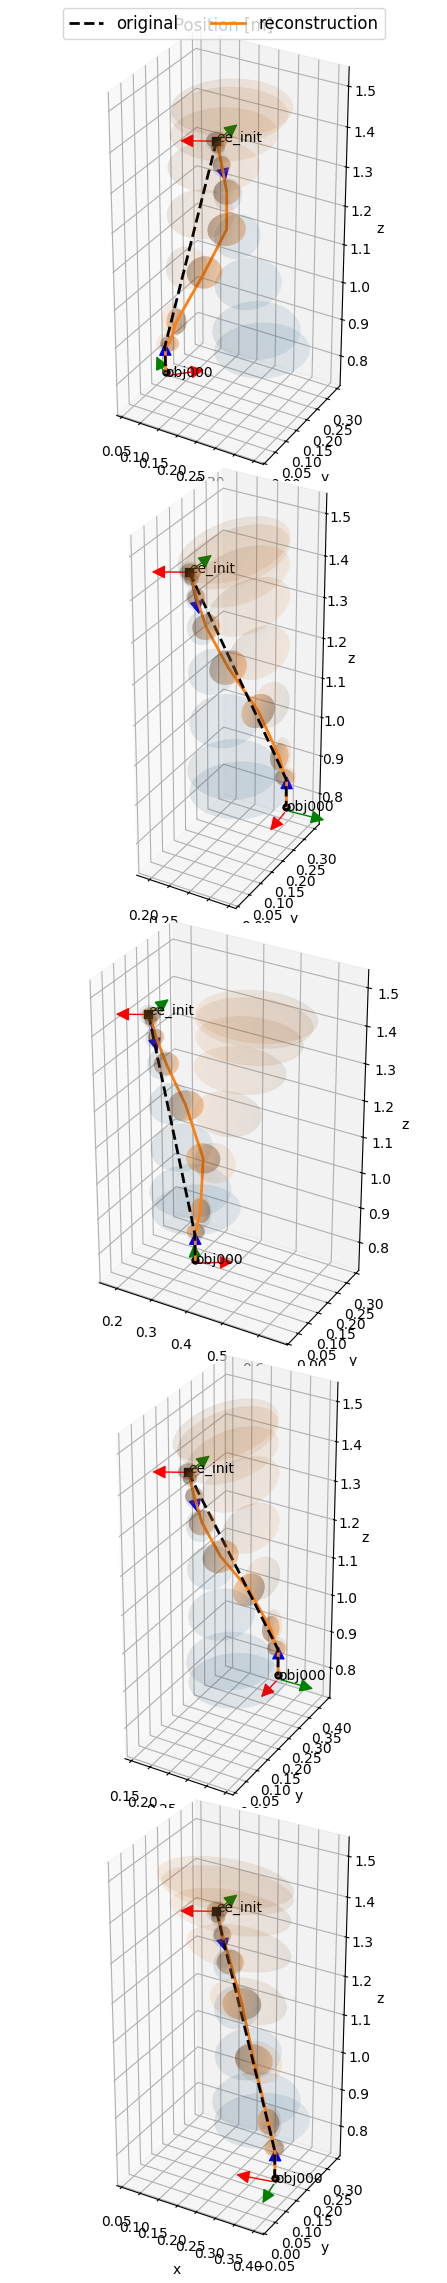

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
